In [32]:
import numpy as np
import os
import PIL
import tensorflow as tf

In [33]:
import pathlib
data_dir = pathlib.Path('../Data/gender/').with_suffix('')

In [34]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2026


In [35]:
batch_size = 32
img_height = 150
img_width = 150

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="training",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='binary'
)
steps_per_epoch = len(train_ds)//batch_size
#train_ds=train_ds.repeat()

Found 2026 files belonging to 2 classes.
Using 1621 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='binary'
)
validation_steps = len(val_ds)//batch_size
#val_ds = val_ds.repeat()

Found 2026 files belonging to 2 classes.
Using 405 files for validation.


In [38]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Persentase data untuk validation set (tidak digunakan)
    subset="validation",   # Menggunakan subset validation set (sebagai test set)
    seed=42,               # Seed untuk random splitting
    image_size=(150, 150), # Ukuran gambar yang diinginkan
    batch_size=batch_size,
    label_mode='binary'
)

Found 2026 files belonging to 2 classes.
Using 405 files for validation.


In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# Create an ImageDataGenerator object with the desired arguments for data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotasi gambar dalam rentang 20 derajat
    width_shift_range=0.2,  # Perpindahan horizontal gambar
    height_shift_range=0.2,  # Perpindahan vertikal gambar
    shear_range=0.2,  # Peregangan gambar
    zoom_range=0.2,  # Perbesaran gambar
    horizontal_flip=True,  # Flip horizontal gambar
    fill_mode='nearest'  # Cara mengisi piksel kosong setelah augmentasi
)

In [40]:
# Define a function that applies the ImageDataGenerator object to each image
def augment_image(image, label):
  # Convert the image to numpy array and reshape it to (1, height, width, channels)
  image = tf.expand_dims(image, 0)
  # Apply the ImageDataGenerator object and get the augmented image
  image = data_gen(image)[0]
  # Convert the image back to tensor and return it with the label
  return tf.convert_to_tensor(image), label

In [42]:
train_ds = train_ds.map(augment_image)

TypeError: in user code:

    File "C:\Users\ribhanhadyan\AppData\Local\Temp\ipykernel_14144\2721390684.py", line 6, in augment_image  *
        image = data_gen(image)[0]

    TypeError: 'ImageDataGenerator' object is not callable


In [8]:
class_name = val_ds.class_names
class_name

['female', 'male']

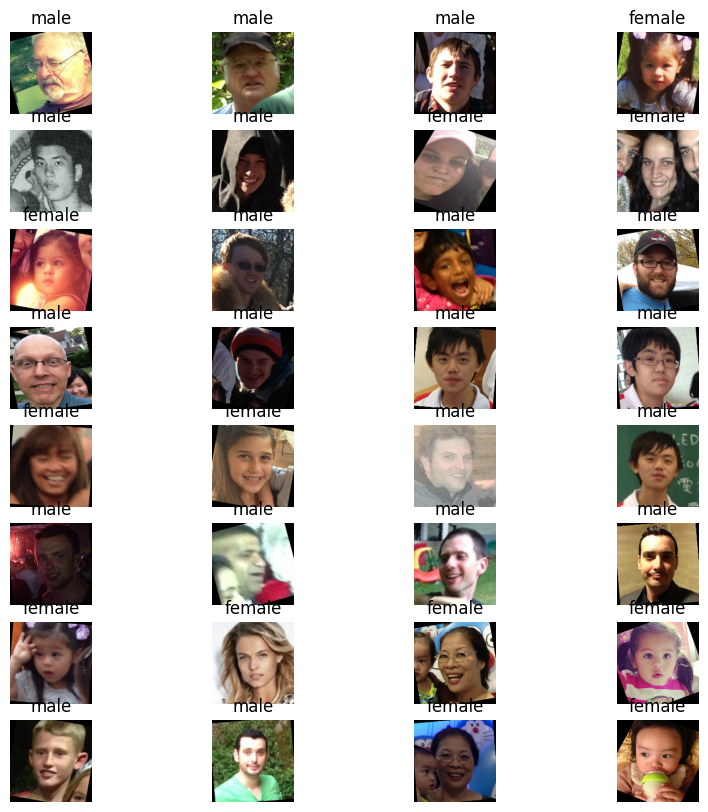

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(32):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[int(labels[i][0].numpy())])
        plt.axis('off')

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32, 1)


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
normalized_train = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

normalized_train = normalized_train.repeat()

0.0 1.0


In [13]:
normalized_val = val_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_val))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.011119644 1.0


In [14]:
normalized_test = test_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_test))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.00029957262 0.9986384


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_train_ds = normalized_train.prefetch(buffer_size=AUTOTUNE)#.cache(filename='cache')
normalized_val_ds = normalized_val.cache(filename='cache')#.prefetch(buffer_size=AUTOTUNE)

normalized_train_ds = normalized_train_ds.repeat()
#normalized_val_ds = normalized_val_ds.repeat()

In [16]:
normalized_test_ds = normalized_test.cache(filename='cache')#.prefetch(buffer_size=AUTOTUNE)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet import MobileNet
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  base_model = MobileNet(weights='imagenet', include_top=False)
  base_model.trainable = True
  for layer in base_model.layers[:150]:
    layer.trainable = False
#
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  #model = tf.keras.models.Sequential([
  #    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Flatten(),
  #    tf.keras.layers.Dense(512,activation='relu'),
  #    tf.keras.layers.Dropout(0.5),
  #    tf.keras.layers.Dense(1,activation='sigmoid')
  #])

  
  model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [18]:
model = create_model()

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, mode='max', min_delta=0.02, baseline=0.98)
#callbacks =[early_stopping]

history = model.fit(normalized_train_ds,
                    epochs=150,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=normalized_val#,
                    #validation_steps=validation_steps
                    #callbacks=callbacks
                    )

Epoch 1/150
1/1 [==============================] - 9s 9s/step - loss: 1.6796 - accuracy: 0.5000 - val_loss: 0.9020 - val_accuracy: 0.4642
Epoch 2/150
1/1 [==============================] - 4s 4s/step - loss: 0.9222 - accuracy: 0.5938 - val_loss: 0.8110 - val_accuracy: 0.5136
Epoch 3/150
1/1 [==============================] - 4s 4s/step - loss: 0.7359 - accuracy: 0.6250 - val_loss: 0.7127 - val_accuracy: 0.5827
Epoch 4/150
1/1 [==============================] - 5s 5s/step - loss: 0.8779 - accuracy: 0.4062 - val_loss: 0.6365 - val_accuracy: 0.6543
Epoch 5/150
1/1 [==============================] - 5s 5s/step - loss: 0.8301 - accuracy: 0.4688 - val_loss: 0.5787 - val_accuracy: 0.6864
Epoch 6/150
1/1 [==============================] - 5s 5s/step - loss: 0.5715 - accuracy: 0.7500 - val_loss: 0.5291 - val_accuracy: 0.7333
Epoch 7/150
1/1 [==============================] - 5s 5s/step - loss: 0.6661 - accuracy: 0.5938 - val_loss: 0.5325 - val_accuracy: 0.7432
Epoch 8/150
1/1 [=================

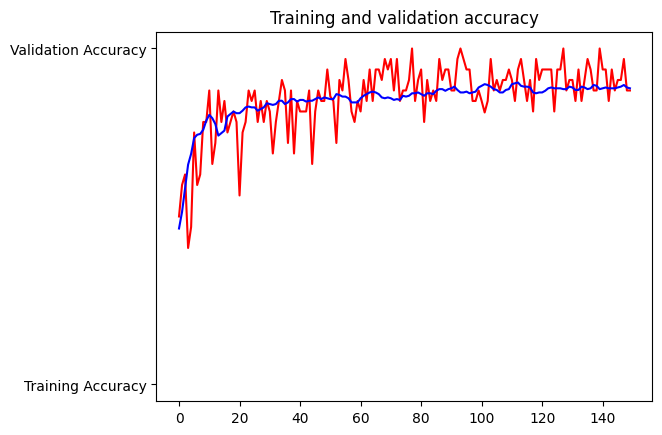

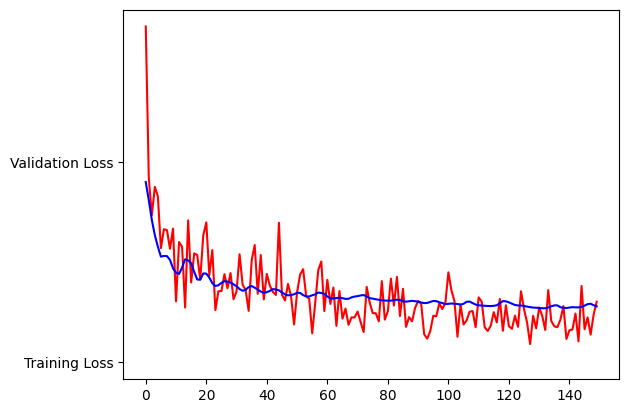

In [19]:
import matplotlib.pyplot as plt
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [30]:
tf.keras.models.save_model(model,'../Models/gender_models/3/')

INFO:tensorflow:Assets written to: ../Models/gender_models/3/assets


INFO:tensorflow:Assets written to: ../Models/gender_models/3/assets


In [31]:
model.save('../Models/gender_models/3/model.h5')

In [20]:
model.evaluate(normalized_test)

13/13 [==============================] - 3s 243ms/step - loss: 0.1854 - accuracy: 0.9235


[0.18541266024112701, 0.9234567880630493]

1/1 [==============================] - 0s 41ms/step
[[0.8951539]]
['female', 'male']
status :male


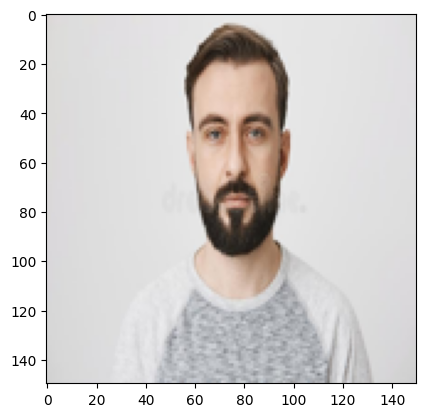

In [29]:
import PIL
import numpy as np
img = PIL.Image.open('E:/download/5.jpg')

img = img.resize((150,150))

image = np.array(img)/255.0
image = image.reshape((1,150,150,3))

predict = class_name[1 if model.predict(image)>=0.5 else 0]
print(model.predict(image))
print(class_name)
print(f'status :{predict}')
plt.imshow(img)